# Model Selection

As this is a binary classification problem, we fit the classification model

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import time

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, roc_auc_score, plot_roc_curve

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text


%matplotlib inline

# Set option to see the full string
pd.set_option('display.max_colwidth', 1000)

### Import Data

In [2]:
final_posts = pd.read_csv('./datasets/final_posts.csv')

final_posts['text'] = final_posts['text'].astype(str)
final_posts['text_lemma'] = final_posts['text_lemma'].astype(str)
final_posts['text_stemming'] = final_posts['text_stemming'].astype(str)

In [3]:
final_posts.head()

,text,text_lemma,text_stemming,subreddit
0,custom status saw this dude playing mw change his game to a whenever he wanted anyone know how he did that,custom status saw this dude playing mw change his game to a whenever he wanted anyone know how he did that,custom statu saw thi dude play mw chang hi game to a whenev he want anyon know how he did that,1
1,are you still able to buy doom xbla edition i wanna buy it for its online co-op and deathmatch its most likely dead but i have a friend i can do co-op with i tried to buy it off of microsoft s website but all i could do was get the demo i than tried to buy it on my from the demo but it didn t let me all i can do is play the demo which doesn t have online,are you still able to buy doom xbla edition i wanna buy it for it online co op and deathmatch it most likely dead but i have a friend i can do co op with i tried to buy it off of microsoft s website but all i could do wa get the demo i than tried to buy it on my from the demo but it didn t let me all i can do is play the demo which doesn t have online,are you still abl to buy doom xbla edit i wanna buy it for it onlin co op and deathmatch it most like dead but i have a friend i can do co op with i tri to buy it off of microsoft s websit but all i could do wa get the demo i than tri to buy it on my from the demo but it didn t let me all i can do is play the demo which doesn t have onlin,1
2,image download how do i download an image from microsoft edge with the new update i could do it perfectly fine last month with the normal way but with the new update i can’t anymore… please help,image download how do i download an image from microsoft edge with the new update i could do it perfectly fine last month with the normal way but with the new update i can t anymore please help,imag download how do i download an imag from microsoft edg with the new updat i could do it perfectli fine last month with the normal way but with the new updat i can t anymor pleas help,1
3,hard drive so i just got a new hard drive a 8tb hard drive from walmart in the section and every time i download a newer game on it it says newer games need a faster harder and i thought that this was stupid because you have a hard sponsored by and it says you either need to move it to internal or a storage add on card but is there any way to fix this problem,hard drive so i just got a new hard drive a 8tb hard drive from walmart in the section and every time i download a newer game on it it say newer game need a faster harder and i thought that this wa stupid because you have a hard sponsored by and it say you either need to move it to internal or a storage add on card but is there any way to fix this problem,hard drive so i just got a new hard drive a 8tb hard drive from walmart in the section and everi time i download a newer game on it it say newer game need a faster harder and i thought that thi wa stupid becaus you have a hard sponsor by and it say you either need to move it to intern or a storag add on card but is there ani way to fix thi problem,1
4,does the gold to live ultimate conversion still work planning on purchasing two years of live gold next week and want to double check with you guys if the conversion to ultimate game-pass still works i m new to as i just purchased a series s so i plan on using the months of ultimate for a dollar as my conversation method hopefully i ll be good i m very nervous,doe the gold to live ultimate conversion still work planning on purchasing two year of live gold next week and want to double check with you guy if the conversion to ultimate game pas still work i m new to a i just purchased a series s so i plan on using the month of ultimate for a dollar a my conversation method hopefully i ll be good i m very nervous,doe the gold to live ultim convers still work plan on purchas two year of live gold next week and want to doubl check with you guy if the convers to ultim game pass still work i m new to as i just purchas a seri s so

### Baseline Score

In [4]:
final_posts['subreddit'].value_counts(normalize=True)

1    0.542935
0    0.457065
Name: subreddit, dtype: float64

When taking into account the whole dataset, the baseline score is 54.3%

## Create Function to model

In [5]:
# Define function to calculate scores
def classification_model(model, params):    
    
    # Create empty dictionary to append scores into dataframe
    d = []
    
    # List of text types
    text_type = ['text', 'text_lemma','text_stemming']
    
    # Iterate through text types
    for text in text_type:
    
        # Train test split
        X = final_posts[text]
        y = final_posts['subreddit']


        X_train, X_test, y_train, y_test = train_test_split(
                                            X, 
                                            y, 
                                            test_size = 0.33, 
                                            random_state = 43, 
                                            stratify = y
        )

        # Pipeline and GridsearchCV for Model
        if model == 'Logistic Regression':
            cvec_pipe = Pipeline([
                ('vec', CountVectorizer(stop_words='english')),
                ('lr', LogisticRegression())
            ])

            tfidf_pipe = Pipeline([
                ('vec', TfidfVectorizer(stop_words='english')),
                ('lr', LogisticRegression())
            ])
        
        elif model == 'Naive Bayes':
            cvec_pipe = Pipeline([
                ('vec', CountVectorizer(stop_words='english')),
                ('nb', MultinomialNB())
            ])

            tfidf_pipe = Pipeline([
                ('vec', TfidfVectorizer(stop_words='english')),
                ('nb', MultinomialNB())
            ])
            
        elif model == 'KNeighbors':
            cvec_pipe = Pipeline([
                ('vec', CountVectorizer(stop_words='english')),
                ('knn', KNeighborsClassifier())
            ])

            tfidf_pipe = Pipeline([
                ('vec', TfidfVectorizer(stop_words='english')),
                ('knn', KNeighborsClassifier())
            ])  
        
        elif model == 'Decision Tree':
            cvec_pipe = Pipeline([
                ('vec', CountVectorizer(stop_words='english')),
                ('dt', DecisionTreeClassifier())
            ])

            tfidf_pipe = Pipeline([
                ('vec', TfidfVectorizer(stop_words='english')),
                ('dt', DecisionTreeClassifier())
            ]) 
        
        elif model == 'Random Forest':
            cvec_pipe = Pipeline([
                ('vec', CountVectorizer(stop_words='english')),
                ('rf', RandomForestClassifier())
            ])

            tfidf_pipe = Pipeline([
                ('vec', TfidfVectorizer(stop_words='english')),
                ('rf', RandomForestClassifier())
            ]) 
            


        # GridSearch for countvectorizer & Tf-idf
        cvec_gs = GridSearchCV(cvec_pipe, params, n_jobs=-1, cv=5)
        tfidf_gs = GridSearchCV(tfidf_pipe, params, n_jobs=-1, cv=5)

        # Starting Time
        start = time.time()

        # Model Fit
        cvec_gs.fit(X_train, y_train)
        tfidf_gs.fit(X_train, y_train)

        # Ending Time
        end = time.time()

        # Predicted y 
        cvec_y_pred = cvec_gs.predict(X_test)
        tfidf_y_pred = tfidf_gs.predict(X_test)


        # Confusion Matrix
        cvec_cm = confusion_matrix(y_test, cvec_y_pred)
        cvec_cm_df = pd.DataFrame(cvec_cm, index=['Actual Playstation', 'Actual Xbox'], 
                            columns=['Predicted Playstation', 'Predicted Xbox'])
        cvec_tn, cvec_fp, cvec_fn, cvec_tp = confusion_matrix(y_test, cvec_y_pred).ravel()
        cvec_cr=classification_report(y_test,tfidf_y_pred)
        cvec_train_score = np.round(cvec_gs.score(X_train, y_train), 3)
        cvec_test_score = np.round(cvec_gs.score(X_test, y_test), 3)
        cvec_time_to_fit = np.round(end - start, 3)
        cvec_accuracy = np.round(accuracy_score(y_test, cvec_y_pred), 3)
        cvec_precision = np.round(precision_score(y_test, cvec_y_pred), 3)
        cvec_recall = np.round(recall_score(y_test, cvec_y_pred), 3)
        cvec_auc = np.round(roc_auc_score(y_test, cvec_y_pred), 3)
        cvec_best_params = cvec_gs.best_params_
        cvec_vec = 'Count Vectorizer'
        model_score(model, cvec_vec, text, cvec_train_score, cvec_test_score, cvec_cm_df, cvec_tn, cvec_fp, cvec_fn, cvec_tp, cvec_cr, cvec_time_to_fit, cvec_accuracy, cvec_best_params)

        # Confusion Matrix
        tfidf_cm = confusion_matrix(y_test, tfidf_y_pred)
        tfidf_cm_df = pd.DataFrame(tfidf_cm, index=['Actual Playstation', 'Actual Xbox'], 
                            columns=['Predicted Playstation', 'Predicted Xbox'])
        tfidf_tn, tfidf_fp, tfidf_fn, tfidf_tp = confusion_matrix(y_test, tfidf_y_pred).ravel()
        tfidf_cr=classification_report(y_test,tfidf_y_pred)
        tfidf_train_score = np.round(tfidf_gs.score(X_train, y_train), 3)
        tfidf_test_score = np.round(tfidf_gs.score(X_test, y_test), 3)
        tfidf_time_to_fit = np.round(end - start, 3)
        tfidf_accuracy = np.round(accuracy_score(y_test, tfidf_y_pred), 3)
        tfidf_precision = np.round(precision_score(y_test, tfidf_y_pred), 3)
        tfidf_recall = np.round(recall_score(y_test, tfidf_y_pred), 3)
        tfidf_auc = np.round(roc_auc_score(y_test, tfidf_y_pred), 3)
        tfidf_best_params = tfidf_gs.best_params_
        tfidf_vec = 'Tf-Idf'
        model_score(model, tfidf_vec, text, tfidf_train_score, tfidf_test_score, tfidf_cm_df, tfidf_tn, tfidf_fp, tfidf_fn, tfidf_tp, tfidf_cr, tfidf_time_to_fit, tfidf_accuracy, tfidf_best_params)

        # Append cvec results to dictionary
        d.append(
            {
                'model': model,
                'vectorizer': cvec_vec,
                'text_type': text,
                'best_params': cvec_best_params,
                'time_to_fit': cvec_time_to_fit,
                'train_score': cvec_train_score,
                'test_score': cvec_test_score,
                'accuracy_score': cvec_accuracy,
                'misclass_score': (1 - cvec_accuracy),
                'precision_score': cvec_precision,
                'recall_score': cvec_recall,
                'auc_score': cvec_auc,
                'tn': cvec_tn,
                'fp': cvec_fp,
                'fn': cvec_fn,
                'tp': cvec_tp,
                
            })
        
        # Append tfidf results to dictionary
        d.append(
            {
                'model': model,
                'vectorizer': tfidf_vec,
                'text_type': text,
                'best_params': tfidf_best_params,
                'time_to_fit': tfidf_time_to_fit,
                'train_score': tfidf_train_score,
                'test_score': tfidf_test_score,
                'accuracy_score': tfidf_accuracy,
                'misclass_score': (1 - tfidf_accuracy),
                'precision_score': tfidf_precision,
                'recall_score': tfidf_recall,
                'auc_score': tfidf_auc,
                'tn': tfidf_tn,
                'fp': tfidf_fp,
                'fn': tfidf_fn,
                'tp': tfidf_tp,
                
            })
    
    
    df = pd.DataFrame(d)
    return df


In [6]:
def model_score(model, vec, text, train_score, test_score, cm_df, tn, fp, fn, tp, cr, time_to_fit, accuracy, best_params):
    

    print('###################################')
    print(f'    {model} with {text} ({vec})'  )
    print('###################################')
    print('\n')
    # Total Time Taken
    print(f'Runtime to fit model: {time_to_fit} seconds')

    # Model scores for train & test
    print(f'Model Train Score: {train_score}')
    print(f'Model Test Score: {test_score}')
    print('\n')

    # Best parameters
    print('Best Parameters')
    print('---------------')
    for k,v in best_params.items():
        print(f'{k}: {v}')
    print('\n')

    print('Classification Metrics')
    print('----------------------')
    print(f'True Negative: {tn}')
    print(f'False Positive: {fp}')
    print(f'False Negative: {fn}')
    print(f'True Positive: {tp}')
    print('')
    print('Classification Matrix')
    print('----------------------')
    print(cm_df)
    print('')
    print('Classification Report')
    print('----------------------')
    print(cr)
    print('')
    print('===========================================================================')
    print('')
    print('')
          
    return

## Logistic Regression

For logistic regression, the probablities describing the possible outcomes of a single trial are modelled using a logistic function. This model works best when all the predictors are independent of each other and assumes data is free of missing values

Will gridsearch on the below parameters.

In [7]:
# Set Parameters 
params = {
    'vec__ngram_range': [(1, 1),(1, 2)],
    'vec__max_features': [2000],
    'vec__max_df': [0.7],
    'vec__min_df': [5],
    'lr__penalty': ['l1','l2'],
    'lr__solver': ['liblinear'],
    'lr__C': [1.0, 0.5, 0.1],
    'lr__max_iter': [10000]
}

logreg_scores = classification_model('Logistic Regression', params)

###################################
    Logistic Regression with text (Count Vectorizer)
###################################


Runtime to fit model: 4.707 seconds
Model Train Score: 0.94
Model Test Score: 0.759


Best Parameters
---------------
lr__C: 0.1
lr__max_iter: 10000
lr__penalty: l2
lr__solver: liblinear
vec__max_df: 0.7
vec__max_features: 2000
vec__min_df: 5
vec__ngram_range: (1, 2)


Classification Metrics
----------------------
True Negative: 268
False Positive: 64
False Negative: 111
True Positive: 284

Classification Matrix
----------------------
                    Predicted Playstation  Predicted Xbox
Actual Playstation                    268              64
Actual Xbox                           111             284

Classification Report
----------------------
              precision    recall  f1-score   support

           0       0.68      0.86      0.76       332
           1       0.85      0.66      0.74       395

    accuracy                           0.75       

In [8]:
# display in order of highest accuracy_score
logreg_scores.sort_values('accuracy_score', ascending=False)

,model,vectorizer,text_type,best_params,time_to_fit,train_score,test_score,accuracy_score,misclass_score,precision_score,recall_score,auc_score,tn,fp,fn,tp
5,Logistic Regression,Tf-Idf,text_stemming,"{'lr__C': 1.0, 'lr__max_iter': 10000, 'lr__penalty': 'l1', 'lr__solver': 'liblinear', 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",2.893,0.818,0.763,0.763,0.237,0.863,0.671,0.772,290,42,130,265
0,Logistic Regression,Count Vectorizer,text,"{'lr__C': 0.1, 'lr__max_iter': 10000, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}",4.707,0.940,0.759,0.759,0.241,0.816,0.719,0.763,268,64,111,284
1,Logistic Regression,Tf-Idf,text,"{'lr__C': 1.0, 'lr__max_iter': 10000, 'lr__penalty': 'l1', 'lr__solver': 'liblinear', 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",4.707,0.816,0.754,0.754,0.246,0.853,0.661,0.763,287,45,134,261
3,Logistic Regression,Tf-Idf,text_lemma,"{'lr__C': 1.0, 'lr__max_iter': 10000, 'lr__penalty': 'l1', 'lr__solver': 'liblinear', 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",2.985,0.818,0.754,0.754,0.246,0.853,0.661,0.763,287,45,134,261
2,Logistic Regression,Count Vectorizer,text_lemma,"{'lr__C': 0.5, 'lr__max_iter': 10000, 'lr__penalty': 'l1', 'lr__solver': 'liblinear', 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}",2.985,0.896,0.752,0.752,0.248,0.819,0.699,0.757,271,61,119,276
4,Logistic Regression,Count Vectorizer,text_stemming,"{'lr__C': 0.5, 'lr__max_iter': 10000, 'lr__penalty': 'l1', 'lr__solver': 'liblinear', 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",2.893,0.896,0.750,0.750,0.250,0.802,0.716,0.753,262,70,112,283


**Observations**

Its observed that the accuracy scores are very similar between models. 
Of the 6 logistic regression models built, using Tf-idf on the stemming text yielded the highest accuracy score. its no surprise as Tf-idf balances out the term frequency with its inverse document frequency.  

Using the orginal text and count vectorizer produced the highest variance. This can be attributed to the original text not having any feature engineering done on it.


## Naive Bayes 

For Naive Bayes, the algorithm is based on Bayes theorem for calculating probabilities and conditional probabilities, assuming the independence of every feature. Generally it should work well for documents classification. They also require only a small amount of training data to estimate the necessary parameters. 

We implemented the Binomial Naive Bayes as its useful for our features where we have 'count how often word occurs in the document".

In [9]:
# Set Parameters 
params = {
    'vec__ngram_range': [(1, 1),(1, 2)],
    'vec__max_features': [2000],
    'vec__max_df': [0.7],
    'vec__min_df': [5],
}

nb_scores = classification_model('Naive Bayes', params)

###################################
    Naive Bayes with text (Count Vectorizer)
###################################


Runtime to fit model: 0.857 seconds
Model Train Score: 0.888
Model Test Score: 0.743


Best Parameters
---------------
vec__max_df: 0.7
vec__max_features: 2000
vec__min_df: 5
vec__ngram_range: (1, 2)


Classification Metrics
----------------------
True Negative: 232
False Positive: 100
False Negative: 87
True Positive: 308

Classification Matrix
----------------------
                    Predicted Playstation  Predicted Xbox
Actual Playstation                    232             100
Actual Xbox                            87             308

Classification Report
----------------------
              precision    recall  f1-score   support

           0       0.79      0.58      0.67       332
           1       0.71      0.87      0.78       395

    accuracy                           0.74       727
   macro avg       0.75      0.73      0.73       727
weighted avg      

In [10]:
nb_scores.sort_values('accuracy_score', ascending=False)

,model,vectorizer,text_type,best_params,time_to_fit,train_score,test_score,accuracy_score,misclass_score,precision_score,recall_score,auc_score,tn,fp,fn,tp
4,Naive Bayes,Count Vectorizer,text_stemming,"{'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}",0.880,0.886,0.754,0.754,0.246,0.762,0.795,0.750,234,98,81,314
5,Naive Bayes,Tf-Idf,text_stemming,"{'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}",0.880,0.883,0.754,0.754,0.246,0.723,0.886,0.741,198,134,45,350
0,Naive Bayes,Count Vectorizer,text,"{'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}",0.857,0.888,0.743,0.743,0.257,0.755,0.780,0.739,232,100,87,308
1,Naive Bayes,Tf-Idf,text,"{'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}",0.857,0.885,0.739,0.739,0.261,0.712,0.871,0.726,193,139,51,344
3,Naive Bayes,Tf-Idf,text_lemma,"{'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}",0.814,0.878,0.739,0.739,0.261,0.711,0.873,0.726,192,140,50,345
2,Naive Bayes,Count Vectorizer,text_lemma,"{'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}",0.814,0.889,0.737,0.737,0.263,0.751,0.772,0.734,231,101,90,305


**Observations**

All 6 training & test scores are similar, between the range of 0.737-0.854. However, the recall score is significantly higher when model uses Tf-idf, meaning we are predicting the playstation subreddit better. As Tf-idf give higher scores to rarer words, it must have identified some that are very useful to the naive bayes model

The time it took to fit the data was the fastest as we are just calculating the conditional probability. In terms of computational power, this model required the least.

## KNeighbors

In [11]:
# Set Parameters 
params = {
    'vec__ngram_range': [(1, 1),(1, 2)],
    'vec__max_features': [2000],
    'vec__max_df': [0.7],
    'vec__min_df': [5],
    'knn__n_neighbors': [1, 3, 5],
    'knn__weights': ['uniform','distance']
}

knn_scores = classification_model('KNeighbors', params)

###################################
    KNeighbors with text (Count Vectorizer)
###################################


Runtime to fit model: 3.395 seconds
Model Train Score: 1.0
Model Test Score: 0.561


Best Parameters
---------------
knn__n_neighbors: 1
knn__weights: uniform
vec__max_df: 0.7
vec__max_features: 2000
vec__min_df: 5
vec__ngram_range: (1, 1)


Classification Metrics
----------------------
True Negative: 206
False Positive: 126
False Negative: 193
True Positive: 202

Classification Matrix
----------------------
                    Predicted Playstation  Predicted Xbox
Actual Playstation                    206             126
Actual Xbox                           193             202

Classification Report
----------------------
              precision    recall  f1-score   support

           0       0.64      0.57      0.60       332
           1       0.67      0.73      0.70       395

    accuracy                           0.66       727
   macro avg       0.65      0.6

In [12]:
knn_scores.sort_values('accuracy_score', ascending=False)

,model,vectorizer,text_type,best_params,time_to_fit,train_score,test_score,accuracy_score,misclass_score,precision_score,recall_score,auc_score,tn,fp,fn,tp
1,KNeighbors,Tf-Idf,text,"{'knn__n_neighbors': 5, 'knn__weights': 'distance', 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",3.395,1.0,0.656,0.656,0.344,0.668,0.729,0.649,189,143,107,288
3,KNeighbors,Tf-Idf,text_lemma,"{'knn__n_neighbors': 5, 'knn__weights': 'distance', 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}",3.192,1.0,0.651,0.651,0.349,0.665,0.719,0.644,189,143,111,284
5,KNeighbors,Tf-Idf,text_stemming,"{'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}",3.235,1.0,0.651,0.651,0.349,0.680,0.673,0.648,207,125,129,266
4,KNeighbors,Count Vectorizer,text_stemming,"{'knn__n_neighbors': 5, 'knn__weights': 'distance', 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",3.235,1.0,0.612,0.612,0.388,0.703,0.496,0.623,249,83,199,196
2,KNeighbors,Count Vectorizer,text_lemma,"{'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",3.192,1.0,0.582,0.582,0.418,0.644,0.514,0.588,220,112,192,203
0,KNeighbors,Count Vectorizer,text,"{'knn__n_neighbors': 1, 'knn__weights': 'uniform', 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",3.395,1.0,0.561,0.561,0.439,0.616,0.511,0.566,206,126,193,202


**Observations**

For all the Knn models, their accuracy scores were the worst, and are terribly overfitted to the training data. This was kinda expected as knn's features are based on distance on a vector space, while the vectorizers are a bag of counts that are not represented well in this space.

## Decision Tree

In [13]:
# Set Parameters 
params = {
    'vec__ngram_range': [(1, 1),(1, 2)],
    'vec__max_features': [2000],
    'vec__max_df': [0.7],
    'vec__min_df': [5],
    'dt__max_depth': [2, 5, 7],
    'dt__min_samples_split': [5, 10],
    'dt__min_samples_leaf': [2, 3, 4],
    'dt__ccp_alpha': [0, 0.001, 0.01]
}

dt_scores = classification_model('Decision Tree', params)

###################################
    Decision Tree with text (Count Vectorizer)
###################################


Runtime to fit model: 27.138 seconds
Model Train Score: 0.739
Model Test Score: 0.7


Best Parameters
---------------
dt__ccp_alpha: 0.001
dt__max_depth: 7
dt__min_samples_leaf: 4
dt__min_samples_split: 5
vec__max_df: 0.7
vec__max_features: 2000
vec__min_df: 5
vec__ngram_range: (1, 1)


Classification Metrics
----------------------
True Negative: 306
False Positive: 26
False Negative: 192
True Positive: 203

Classification Matrix
----------------------
                    Predicted Playstation  Predicted Xbox
Actual Playstation                    306              26
Actual Xbox                           192             203

Classification Report
----------------------
              precision    recall  f1-score   support

           0       0.61      0.91      0.73       332
           1       0.87      0.51      0.64       395

    accuracy                          

In [14]:
dt_scores.sort_values('accuracy_score', ascending=False)

,model,vectorizer,text_type,best_params,time_to_fit,train_score,test_score,accuracy_score,misclass_score,precision_score,recall_score,auc_score,tn,fp,fn,tp
4,Decision Tree,Count Vectorizer,text_stemming,"{'dt__ccp_alpha': 0, 'dt__max_depth': 7, 'dt__min_samples_leaf': 3, 'dt__min_samples_split': 10, 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",28.429,0.739,0.715,0.715,0.285,0.888,0.544,0.731,305,27,180,215
2,Decision Tree,Count Vectorizer,text_lemma,"{'dt__ccp_alpha': 0.001, 'dt__max_depth': 7, 'dt__min_samples_leaf': 4, 'dt__min_samples_split': 5, 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",27.389,0.739,0.702,0.702,0.298,0.887,0.516,0.719,306,26,191,204
0,Decision Tree,Count Vectorizer,text,"{'dt__ccp_alpha': 0.001, 'dt__max_depth': 7, 'dt__min_samples_leaf': 4, 'dt__min_samples_split': 5, 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",27.138,0.739,0.700,0.700,0.300,0.886,0.514,0.718,306,26,192,203
3,Decision Tree,Tf-Idf,text_lemma,"{'dt__ccp_alpha': 0, 'dt__max_depth': 7, 'dt__min_samples_leaf': 4, 'dt__min_samples_split': 10, 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}",27.389,0.742,0.695,0.695,0.305,0.902,0.491,0.714,311,21,201,194
1,Decision Tree,Tf-Idf,text,"{'dt__ccp_alpha': 0.001, 'dt__max_depth': 7, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5, 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",27.138,0.750,0.692,0.692,0.308,0.870,0.509,0.709,302,30,194,201
5,Decision Tree,Tf-Idf,text_stemming,"{'dt__ccp_alpha': 0.01, 'dt__max_depth': 5, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 5, 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}",28.429,0.714,0.689,0.689,0.311,0.893,0.486,0.708,309,23,203,192


**Observations**

The accuracy scores for decision trees were similar for all 6 models and were relatively low. Decision trees are good for simplicity and interpretation, but they are more limited to learn complicated rules.

## Random Forest

In [15]:
# Set Parameters 
params = {
    'vec__ngram_range': [(1, 1),(1, 2)],
    'vec__max_features': [2000],
    'vec__max_df': [0.7],
    'vec__min_df': [5],
    'rf__n_estimators': [50, 100, 150, 200],
    'rf__max_depth': [2, 4, 6, 8, 10],
}

rf_scores = classification_model('Random Forest', params)

###################################
    Random Forest with text (Count Vectorizer)
###################################


Runtime to fit model: 25.673 seconds
Model Train Score: 0.894
Model Test Score: 0.74


Best Parameters
---------------
rf__max_depth: 10
rf__n_estimators: 200
vec__max_df: 0.7
vec__max_features: 2000
vec__min_df: 5
vec__ngram_range: (1, 1)


Classification Metrics
----------------------
True Negative: 205
False Positive: 127
False Negative: 62
True Positive: 333

Classification Matrix
----------------------
                    Predicted Playstation  Predicted Xbox
Actual Playstation                    205             127
Actual Xbox                            62             333

Classification Report
----------------------
              precision    recall  f1-score   support

           0       0.80      0.58      0.67       332
           1       0.71      0.88      0.79       395

    accuracy                           0.74       727
   macro avg       0.76      0

In [16]:
rf_scores.sort_values('accuracy_score', ascending=False)

,model,vectorizer,text_type,best_params,time_to_fit,train_score,test_score,accuracy_score,misclass_score,precision_score,recall_score,auc_score,tn,fp,fn,tp
5,Random Forest,Tf-Idf,text_stemming,"{'rf__max_depth': 10, 'rf__n_estimators': 100, 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",24.884,0.923,0.747,0.747,0.253,0.732,0.843,0.738,210,122,62,333
1,Random Forest,Tf-Idf,text,"{'rf__max_depth': 10, 'rf__n_estimators': 200, 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}",25.673,0.907,0.743,0.743,0.257,0.714,0.878,0.730,193,139,48,347
0,Random Forest,Count Vectorizer,text,"{'rf__max_depth': 10, 'rf__n_estimators': 200, 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",25.673,0.894,0.740,0.740,0.260,0.724,0.843,0.730,205,127,62,333
4,Random Forest,Count Vectorizer,text_stemming,"{'rf__max_depth': 10, 'rf__n_estimators': 200, 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",24.884,0.904,0.737,0.737,0.263,0.731,0.818,0.730,213,119,72,323
2,Random Forest,Count Vectorizer,text_lemma,"{'rf__max_depth': 10, 'rf__n_estimators': 200, 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",24.377,0.886,0.732,0.732,0.268,0.702,0.878,0.718,185,147,48,347
3,Random Forest,Tf-Idf,text_lemma,"{'rf__max_depth': 10, 'rf__n_estimators': 200, 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",24.377,0.923,0.728,0.728,0.272,0.715,0.830,0.718,201,131,67,328


**Observations**

The time taken for the model is long as it is building multiple decision trees. Generally it fits well to the training data, but not so much the test, seems overfitted, although I thought an advantage of a random forest is it doesn't suffer from overfitting as it takes the average of all the predictions, which lowers the bias. Its possible that the best parameters used for this model can be tweaked further.

## Evaluating the model

After fitting the models and generating the results, we will use the classification metrics to evaluate which model is best. 

To do that, we will merge all the dataframes containing the range of different metrics.

In [17]:
# Concatenate all dataframes containing model scores
frames = [
    logreg_scores, 
    nb_scores, 
    knn_scores, 
    dt_scores, 
    rf_scores
]

all_scores = pd.concat(frames, axis=0)
all_scores = all_scores.reset_index().drop(columns='index', axis=1)

### Classification Accuracy

This shows how many predictions are correct, and in our case, it can predict how good a model is as our classes have a rather balanced distribution (54% and 46%) .

In [18]:
# top 5 performing models based on accuracy_score
all_scores.sort_values('accuracy_score', ascending=False).head(5)

,model,vectorizer,text_type,best_params,time_to_fit,train_score,test_score,accuracy_score,misclass_score,precision_score,recall_score,auc_score,tn,fp,fn,tp
5,Logistic Regression,Tf-Idf,text_stemming,"{'lr__C': 1.0, 'lr__max_iter': 10000, 'lr__penalty': 'l1', 'lr__solver': 'liblinear', 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",2.893,0.818,0.763,0.763,0.237,0.863,0.671,0.772,290,42,130,265
0,Logistic Regression,Count Vectorizer,text,"{'lr__C': 0.1, 'lr__max_iter': 10000, 'lr__penalty': 'l2', 'lr__solver': 'liblinear', 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}",4.707,0.940,0.759,0.759,0.241,0.816,0.719,0.763,268,64,111,284
10,Naive Bayes,Count Vectorizer,text_stemming,"{'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}",0.880,0.886,0.754,0.754,0.246,0.762,0.795,0.750,234,98,81,314
3,Logistic Regression,Tf-Idf,text_lemma,"{'lr__C': 1.0, 'lr__max_iter': 10000, 'lr__penalty': 'l1', 'lr__solver': 'liblinear', 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",2.985,0.818,0.754,0.754,0.246,0.853,0.661,0.763,287,45,134,261
1,Logistic Regression,Tf-Idf,text,"{'lr__C': 1.0, 'lr__max_iter': 10000, 'lr__penalty': 'l1', 'lr__solver': 'liblinear', 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",4.707,0.816,0.754,0.754,0.246,0.853,0.661,0.763,287,45,134,261


### Recall 

We are interested to know how good our models are at correctly predicting positive data. 

In [19]:
# top 5 performing models based on Area Under Curve
all_scores.sort_values('recall_score', ascending=False)[:5]

,model,vectorizer,text_type,best_params,time_to_fit,train_score,test_score,accuracy_score,misclass_score,precision_score,recall_score,auc_score,tn,fp,fn,tp
11,Naive Bayes,Tf-Idf,text_stemming,"{'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}",0.880,0.883,0.754,0.754,0.246,0.723,0.886,0.741,198,134,45,350
26,Random Forest,Count Vectorizer,text_lemma,"{'rf__max_depth': 10, 'rf__n_estimators': 200, 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 1)}",24.377,0.886,0.732,0.732,0.268,0.702,0.878,0.718,185,147,48,347
25,Random Forest,Tf-Idf,text,"{'rf__max_depth': 10, 'rf__n_estimators': 200, 'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}",25.673,0.907,0.743,0.743,0.257,0.714,0.878,0.730,193,139,48,347
9,Naive Bayes,Tf-Idf,text_lemma,"{'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}",0.814,0.878,0.739,0.739,0.261,0.711,0.873,0.726,192,140,50,345
7,Naive Bayes,Tf-Idf,text,"{'vec__max_df': 0.7, 'vec__max_features': 2000, 'vec__min_df': 5, 'vec__ngram_range': (1, 2)}",0.857,0.885,0.739,0.739,0.261,0.712,0.871,0.726,193,139,51,344


### Best Model (Linear Regression using Tf-idf Vectorizer)

I have selected the logistic regresison model using the Tf-idf vectorizer on the text stemming data as it has the highest accuracy score with a reasonable variance and bias, somewhat of a best fit. It also has a high AUC score of 0.84, which denotes good performance. Below, we will explore this model in further detail to see what we can infer from its misclassification rate and feature importance.

Naive Bayes Model with Tf-idf
Model Train Score: 0.818
Model Test Score: 0.763


Best Parameters
---------------
lr__C: 1.0
lr__max_iter: 10000
lr__penalty: l1
lr__solver: liblinear
vec__max_df: 0.7
vec__max_features: 2000
vec__min_df: 5
vec__ngram_range: (1, 1)


Classification Metrics
----------------------
True Negative: 290
False Positive: 42
False Negative: 130
True Positive: 265


Classification Matrix
----------------------
                    Predicted Playstation  Predicted Xbox
Actual Playstation                    290              42
Actual Xbox                           130             265


Classification Report
----------------------
              precision    recall  f1-score   support

           0       0.69      0.87      0.77       332
           1       0.86      0.67      0.75       395

    accuracy                           0.76       727
   macro avg       0.78      0.77      0.76       727
weighted avg       0.78      0.76      0.76       727



0.7721900259264

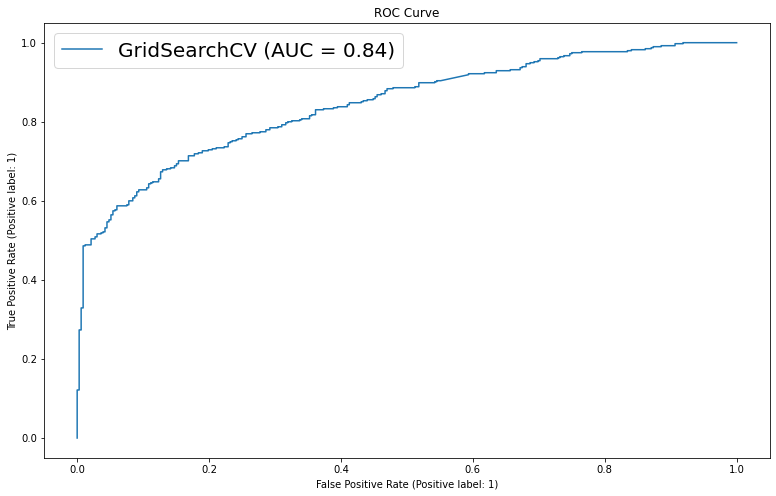

In [25]:
# Define the target and dependent variables
X = final_posts['text_stemming']
y = final_posts['subreddit']


# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
                                        X, 
                                        y, 
                                        test_size = 0.33, 
                                        random_state = 43, 
                                        stratify = y
)



# Pipeline and GridsearchCV for LogisticRegression and CountVectorizer
pipe_gs = Pipeline([
    ('vec', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression())
])

# Set Parameters 
pipe_gs_params = {'vec__ngram_range': [(1, 1)],
                  'vec__max_features': [2000],
                  'vec__max_df': [0.7],
                  'vec__min_df': [5],  
                  'lr__C': [1.0], 
                  'lr__max_iter': [10000], 
                  'lr__penalty': ['l1'], 
                  'lr__solver': ['liblinear'],
}

gs = GridSearchCV(pipe_gs, pipe_gs_params, cv=5)

gs.fit(X_train,y_train)

# Predicted y 
y_pred = gs.predict(X_test)

# Confusion Matrix
cm=confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['Actual Playstation', 'Actual Xbox'], 
                    columns=['Predicted Playstation', 'Predicted Xbox'])
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
cr=classification_report(y_test,y_pred)


print(f'Naive Bayes Model with Tf-idf')
print(f'Model Train Score: {np.round(gs.score(X_train, y_train), 3)}')
print(f'Model Test Score: {np.round(gs.score(X_test, y_test), 3)}')
print('\n')
print('Best Parameters')
print('---------------')
for k,v in gs.best_params_.items():
    print(f'{k}: {v}')
print('\n')
print('Classification Metrics')
print('----------------------')
print(f'True Negative: {tn}')
print(f'False Positive: {fp}')
print(f'False Negative: {fn}')
print(f'True Positive: {tp}')
print('\n')
print('Classification Matrix')
print('----------------------')
print(cm_df)
print('\n')
print('Classification Report')
print('----------------------')
print(cr)
print('\n')
print(roc_auc_score(y_test, y_pred))
print('\n')

fig, ax = plt.subplots(figsize=(13, 8))
plot_roc_curve(gs, X_test, y_test, ax=ax)
plt.legend(prop={"size":20})
plt.title('ROC Curve');

#plt.figure(figsize=(13, 8))
#plt.scatter(X_test, y_test, s= 10)
#plt.plot(X_test,
         #gs.predict_proba(X_test)[:,1],
         #color = 'grey', alpha = 0.8, lw = 3);


### Misclassification analysis

The model produces some false positives and false negatives, hence we'll want to explore the texts for all misclassified posts. Its observed that predicting playstation when its actually xbox has the highest misclassification. 

In [21]:
# Create a pandas dataframe for misclassified posts
pred_series = pd.Series(y_pred, name='predict')
pred_series.index = y_test.index
df = pd.concat([y_test,pred_series], axis=1)

# False Negatives
idx = df[(df['predict'] == 0) &  (df['subreddit'] == 1)].index

tmp_lst = []

for i in idx:
    tmp_lst.append(final_posts.loc[i,'text_lemma'])

print(f'There are {len(tmp_lst)} false negatives')

tmp_lst

There are 130 false negatives


['is is the minimum shown hello if there is let s suppose only who got the achievement will it show or will it show i am trying to get a very difficult achievement in curse of the dead god and i wa wondering if it is possible that the achievement rate could be even lower or not',
 'thought on some kind of class action against for the resent rdr2 mess up hey so you may have noticed seemingly a lot of people have paid for rdr2 story mode when online wa on game pas and since online left gp haven t been unable to access it i think that go to show we all had reasonable expectation and assumption story mode would work regardless of online s gp presence why would they make it an option to buy it if you couldn t access it after the fact asking for more money to play what you ve purchased is extortionate behaviour not to mention predatory a they new this would happen once online left gp i also think it s reasonable a evidenced by the amount of people this ha stung that purchasing story mode all

**Observations**

Honestly, reading some of the misclassified text, I would intuitively be able to classify them based on some key words. It is possible that there might not be enough data in our set to make the feature important. Doing some research, I noticed that the playstation subreddit is mostly used as a help site (like Quora), as they also have subreddit posts for each of their consoles (r/ps3, r/ps4, r/ps5, r/xboxseries etc.)

### Feature Importance

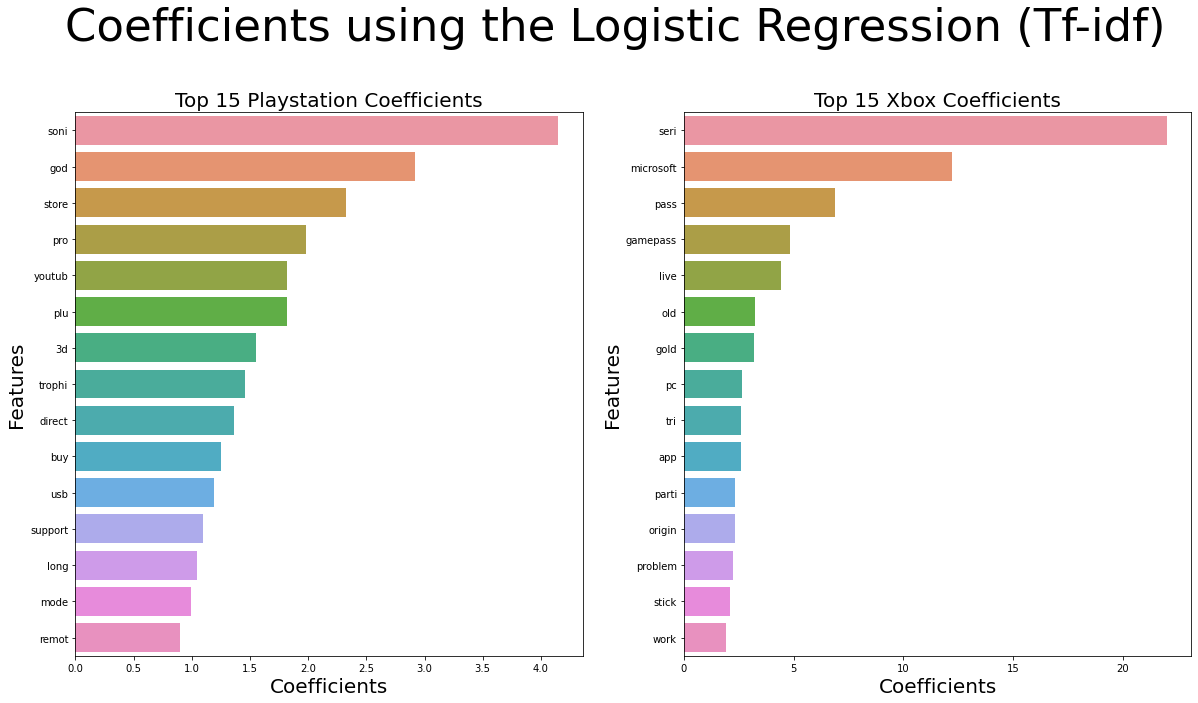

In [22]:
coeff = gs.best_estimator_['lr'].coef_[0]


# Create a dataframe of coefficients 
coefficients = pd.DataFrame({'feature':gs.best_estimator_['vec'].get_feature_names(),
                            'coef': coeff,
                            'abs_coef':np.abs(coeff)})

# Sort dataframe values according to absolute value in descending order
coefficients.sort_values('abs_coef', inplace=True, ascending=False)

# Features that are most important
coefficients[coefficients['coef'] != 0]

playstation_coef = coefficients[['feature','coef']].sort_values('coef', ascending=True).head(15)
xbox_coef = coefficients[['feature','coef']].sort_values('coef', ascending=False).head(15)

# Plot top 15 features for best model
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 10))
fig.suptitle(
    t = (f'Coefficients using the Logistic Regression (Tf-idf)'),
    size = 45,
    va = 'baseline',
    weight = 0.3
)

sns.barplot(data=playstation_coef, x=abs(playstation_coef['coef']), y='feature', ax=ax1)
ax1.set_title(f'Top 15 Playstation Coefficients',size=20)
ax1.set_ylabel(f'Features',size=20)
ax1.set_xlabel(f'Coefficients',size=20)

sns.barplot(data=xbox_coef, x='coef', y='feature', ax=ax2)
ax2.set_title(f'Top 15 Xbox Coefficients',size=20)
ax2.set_ylabel(f'Features',size=20)
ax2.set_xlabel(f'Coefficients',size=20);

**Observations**

As these are stemmatized words, we can see the top coefficients represent the company that build the consoles, the popular games within the time the posts were taken, and the features of the console. 

Because of the logit function, logistic regression coefficients represent the log odds that an observation is in the target class (“1”) given the values of its X variables. Thus, these log odd coefficients need to be converted to regular odds in order to make sense of them.

“For every one-unit increase in the coefficient, the odds that the observation is in the subreddit are [coefficient] times as large as the odds that the observation is not in (y class) when all other variables are held constant.”




In [23]:
playstation_coef

,feature,coef
1023,soni,-4.150638
472,god,-2.919817
1060,store,-2.321417
839,pro,-1.984529
1245,youtub,-1.816744
815,plu,-1.815160
8,3d,-1.549496
1134,trophi,-1.457071
305,direct,-1.366229
162,buy,-1.247734


In [24]:
xbox_coef

,feature,coef
980,seri,22.034720
686,microsoft,12.206536
786,pass,6.871292
456,gamepass,4.816883
632,live,4.411900
758,old,3.213819
474,gold,3.205360
794,pc,2.631874
1130,tri,2.579883
69,app,2.578024


## Conclusion and Recommendation

It would appear that there is evidence within the data from subreddit posts, users have discussions off-topic, read off different sources, and sometimes use the reddit to connect personally with the subreddit community. 

Of all the models, the Logistic Regression model performed consistently with the lowest bias and variance, I also found that it performs well with features that are strongly correlated. I conclude that the subreddit posts consist of many correlated text, though we tried to deal with it using feature engineering like ngrams.

Of the 172 posts misclassified, 130 posts was the actual xbox posts were predicted as playstation posts. Looking at the original text, I would iterate back to do some feature engineering, and do further EDA on the missclassified text to identify if the post had tokens that caused the misclassification, or the text was generalized between both subreddits.

Given that the topics discussed and latest trends are constantly changing, the EDA done on our model will be less effective outside the period of time of our webscraped data. We can still retrain the model by feeding it with new data.


As there seems to be a stronger coefficient  We could improve on the model by scraping from the subreddit comments and other relevant subposts (r/ps4, r/ps5, r/xboxseries etc.)